# Beta-Binomial Conjugate Prior

Prior: $\theta \sim Beta(\alpha,\beta)$

Likelihood: $ X|\theta \sim Binomial(n,\theta)$

Posterior (conjugate): $ \theta|X \sim Beta(\alpha + X, \beta + n - X)$

In [14]:
import numpy as np
from scipy.stats import beta as betapdf
from scipy.stats import binom
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Prior Distribution
alpha = 2.0
beta = 5.0

# Likelihood Observations
n_obs = 25
x_success = 15


In [3]:
# Expected Posterior Distribution Parameters
alpha_post = alpha + x_success
beta_post = beta + n_obs - x_success
mu = alpha_post / (alpha_post + beta_post)
sd = np.sqrt((alpha_post * beta_post) / ((alpha_post + beta_post)**2 * (alpha_post + beta_post + 1)))
print(f"Posterior Mean: {mu:.4f}, Posterior Standard Deviation: {sd:.6f}")

Posterior Mean: 0.5312, Posterior Standard Deviation: 0.086869


In [4]:
# Draw samples from the posterior distribution
n_samples = 100000
theta_samples = np.random.beta(alpha_post, beta_post, n_samples)
post_mean = np.mean(theta_samples)
post_std = np.std(theta_samples)
print(f"Sampled Posterior Mean: {post_mean:.4f}, Sampled Posterior Standard Deviation: {post_std:.6f}")

Sampled Posterior Mean: 0.5316, Sampled Posterior Standard Deviation: 0.086597


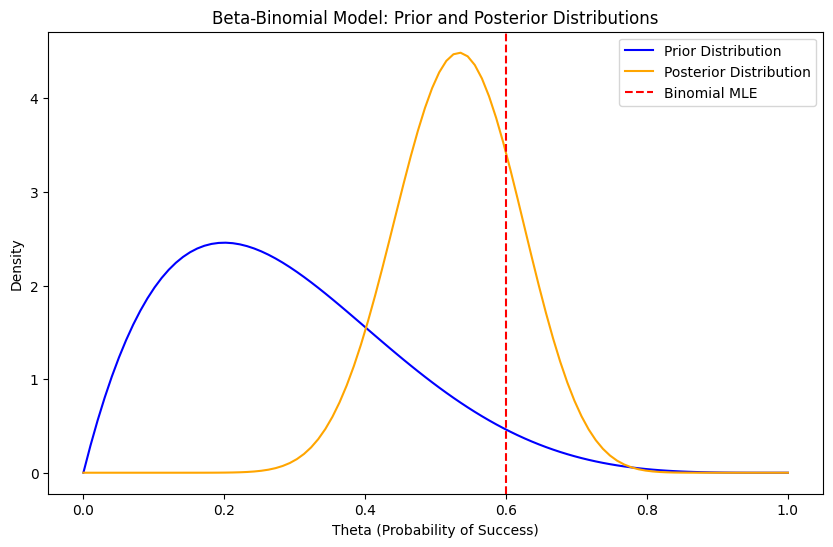

In [5]:
# Plot the prior and posterior distributions
x = np.linspace(0, 1, 100)
prior_pdf = betapdf.pdf(x, alpha, beta)
posterior_pdf = betapdf.pdf(x, alpha_post, beta_post)

plt.figure(figsize=(10, 6))
plt.plot(x, prior_pdf, label='Prior Distribution', color='blue')
plt.plot(x, posterior_pdf, label='Posterior Distribution', color='orange')
plt.title('Beta-Binomial Model: Prior and Posterior Distributions')
plt.xlabel('Theta (Probability of Success)')
plt.ylabel('Density')
plt.axvline(x=x_success/n_obs, color='red', linestyle='--', label='Binomial MLE')
plt.legend()
plt.show()


# Beta-Binomial MCMC (Assume Prior is not Conjugate)

Prior: $\theta \sim Beta(\alpha,\beta)$

Likelihood: $ X|\theta \sim Binomial(n,\theta)$

Posterior: $\frac{P(X|\theta)P(\theta)}{P(X)}  \sim P(X|\theta)P(\theta)$

In [6]:
# Prior Distribution
alpha = 2.0
beta = 5.0

# Likelihood Observations
n_obs = 25
x_success = 15

In [7]:
# Proposal Function to Simulate Posterior Denisty
def post_density(n_obs, x_success, alpha, beta, theta):
    likelihood = binom.pmf(x_success, n_obs, theta)
    prior = betapdf.pdf(theta, alpha, beta)
    posterior_density = prior * likelihood
    return posterior_density

In [8]:
# Proposal Function to Simulate New Posterior Samples
def proposal(old_val):
    val = np.random.normal(loc=old_val, scale=0.05)
    if val < 0:
        val = 0.01
    if val > 1:
        val = 0.99
    return val

In [9]:
# MCMC Sampling
post_samples = 10000
burn_in = 1000
theta_samples = np.zeros(post_samples)
theta_samples[0] = 0.5

for i in range(1,post_samples):
    new_theta = proposal(old_val=theta_samples[i-1])
    new_density = post_density(n_obs, x_success, alpha, beta, new_theta)
    old_density = post_density(n_obs, x_success, alpha, beta, theta_samples[i-1])
    acceptance_ratio = new_density / old_density
    if acceptance_ratio >= 1 or np.random.rand() < acceptance_ratio:
        theta_samples[i] = new_theta
    else:
        theta_samples[i] = theta_samples[i-1]

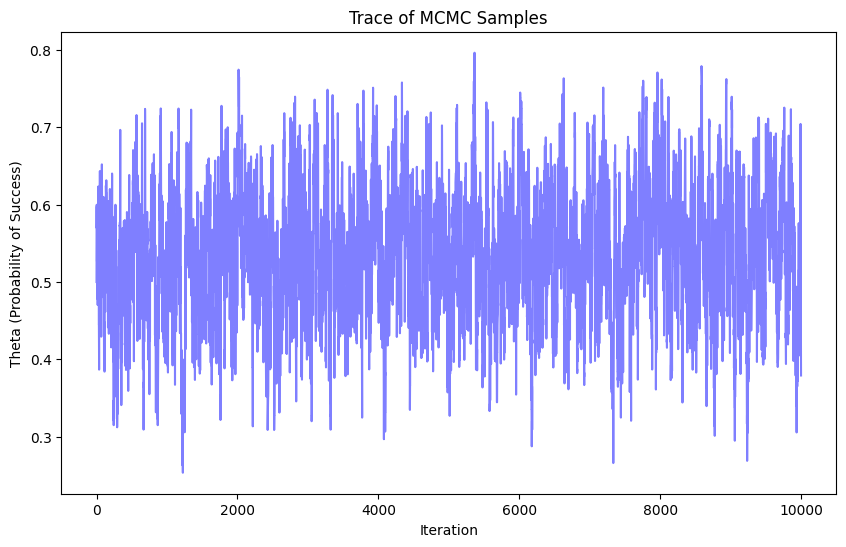

In [10]:
# Trace Plot
plt.figure(figsize=(10, 6))
plt.plot(theta_samples, color='blue', alpha=0.5)
plt.title('Trace of MCMC Samples')
plt.xlabel('Iteration')
plt.ylabel('Theta (Probability of Success)')
plt.show()

In [11]:
# Parameter Estimates
theta_samples_post_burnin = theta_samples[burn_in:]
post_mean_mcmc = np.mean(theta_samples_post_burnin)
post_std_mcmc = np.std(theta_samples_post_burnin)
print(f"MCMC Posterior Mean: {post_mean_mcmc:.4f}, MCMC Posterior Standard Deviation: {post_std_mcmc:.6f}")

MCMC Posterior Mean: 0.5369, MCMC Posterior Standard Deviation: 0.087742


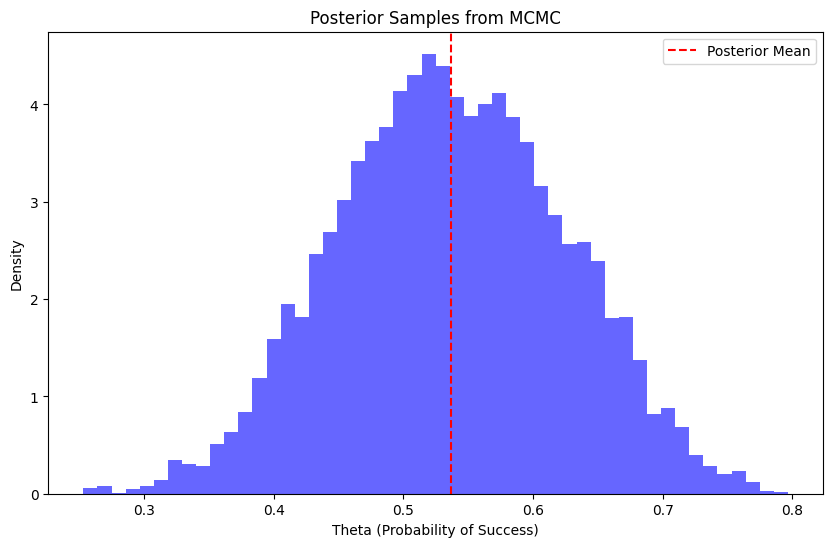

In [12]:
# Plot the posterior samples
plt.figure(figsize=(10, 6))
plt.hist(theta_samples_post_burnin, bins=50, density=True, alpha=0.6, color='blue')
plt.title('Posterior Samples from MCMC')
plt.xlabel('Theta (Probability of Success)')
plt.ylabel('Density')
plt.axvline(x=theta_samples_post_burnin.mean(), color='red', linestyle='--', label='Posterior Mean')
plt.legend()
plt.show()


In [20]:
df = pd.DataFrame({
    'Mean': [mu, post_mean, post_mean_mcmc],
    'Std Dev': [sd, post_std, post_std_mcmc]
}, index=['True Values', 'Conjugate Prior Values', 'MCMC Values'])

df

,Mean,Std Dev
True Values,0.531250,0.086869
Conjugate Prior Values,0.531604,0.086597
MCMC Values,0.536942,0.087742
